In [1]:
import requests
import json
import csv
import pandas as pd
import os
import time
import matplotlib.pyplot as plt

Nous pouvons filtrer notre recherche de restaurants en fonction de la ville et la catégorie de l'établissement(facultatif), ces catégories sont disponibles à cette page : https://docs.developer.yelp.com/docs/resources-categories

Valeur de la variable d'environnement MY_API_KEY :  
rWZMM5zsX_BTHJSKfh73hQI_AJN2OyNJgooc08VmIlFJMU43Q8M3PlqL0-WczdNIZhDh0P3sfiPsRMAIi4DHcTi9MjCeRROeVRD_VthzTKoe3dFYfbN6HrMeai9iZHYx

In [2]:
def get_businesses(location, api_key, categories=None, term="restaurants"):
    """
    Cette fonction interroge l'API Yelp pour obtenir une liste d'établissements en fonction des critères spécifiés.
    
    Args:
        location (str) : Lieu où chercher les établissements.
        api_key (str) : Clé d'API Yelp pour authentifier la requête.
        categories (str, optionnel) : Catégories d'établissements à rechercher.
        term (str, optionnel) : Terme de recherche. Par défaut, il s'agit de "restaurants".

    Returns:
        list : Liste de dictionnaires où chaque dictionnaire représente les détails d'un établissement.
    """
    headers = {"Authorization": "Bearer %s" % api_key}
    url = "https://api.yelp.com/v3/businesses/search"
    data = {}
    offset = 0
    while len(data) < 200:
        params = {
            "limit": 50,
            "location": location,
            "term": term,
            "offset": offset,
            "categories": categories,  
        }
        response = requests.get(url, headers=headers, params=params)
        if response.status_code == 200:
            businesses = response.json()["businesses"]
            print(f"Received {len(businesses)} businesses from Yelp API.")  
            for business in businesses:
                if business["id"] not in data:
                    data[business["id"]] = business
        elif response.status_code == 400:
            print("400 Bad Request")
            break
        print(f"Currently, {len(data)} unique businesses collected.")  
        offset += 50
    print(f"Total unique businesses collected: {len(data)}.") 
    return list(data.values())  



def get_reviews(business_id, api_key):
    """
    Cette fonction récupère les avis d'un établissement spécifique à partir de l'API Yelp.
    
    Args:
        business_id (str) : ID de l'établissement pour lequel récupérer les avis.
        api_key (str) : Clé d'API Yelp pour authentifier la requête.
        
    Returns:
        list : Liste de dictionnaires où chaque dictionnaire représente un avis pour l'établissement.
    """
    headers = {"Authorization": "Bearer %s" % api_key}
    url = f"https://api.yelp.com/v3/businesses/{business_id}/reviews"
    try:
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            return response.json()["reviews"]
    except:
        print(f"Failed to get reviews for business id {business_id}")
    return []


def collect_and_write_data(location, api_key, categories):
    """
    Cette fonction collecte les données des établissements et de leurs avis à partir de l'API Yelp 
    et les écrit dans un fichier CSV.
    
    Args:
        location (str) : Lieu où chercher les établissements.
        api_key (str) : Clé d'API Yelp pour authentifier la requête.
        categories (str) : Catégories d'établissements à rechercher.
    """
    businesses = get_businesses(location, api_key, categories)
    with open("yelp_data.csv", "w", newline="", encoding="utf-8") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(
            [
                "business_id",
                "name",
                "rating",
                "review_count",
                "category",
                "address",
                "city",
                "zip_code",
                "review_text",
                "review_rating",
            ]
        )
        for business in businesses:
            business_id = business["id"]
            reviews = get_reviews(business_id, api_key)
            for review in reviews:
                writer.writerow(
                    [
                        business_id,
                        business["name"],
                        business["rating"],
                        business["review_count"],
                        ", ".join([cat["title"] for cat in business["categories"]]),
                        business["location"]["address1"],
                        business["location"]["city"],
                        business["location"]["zip_code"],
                        review["text"],
                        review["rating"],
                    ]
                )
            


api_key = os.getenv("MY_API_KEY")
location = "Paris"
categories = "french"
collect_and_write_data(location, api_key, categories)

Received 50 businesses from Yelp API.
Currently, 50 unique businesses collected.
Received 50 businesses from Yelp API.
Currently, 100 unique businesses collected.
Received 50 businesses from Yelp API.
Currently, 150 unique businesses collected.
Received 50 businesses from Yelp API.
Currently, 200 unique businesses collected.
Total unique businesses collected: 200.


In [3]:
df = pd.read_csv("yelp_data.csv")

In [4]:
df

,business_id,name,rating,review_count,category,address,city,zip_code,review_text,review_rating
0,-0iLH7iQNYtoURciDpJf6w,Le Comptoir de la Gastronomie,4.5,1240,French,34 rue Montmartre,Paris,75001,Wow. What an amazing restaurant and a must try...,5
1,-0iLH7iQNYtoURciDpJf6w,Le Comptoir de la Gastronomie,4.5,1240,French,34 rue Montmartre,Paris,75001,"Situated in the heart of Paris, on an assuming...",5
2,-0iLH7iQNYtoURciDpJf6w,Le Comptoir de la Gastronomie,4.5,1240,French,34 rue Montmartre,Paris,75001,Great place. 90% of the guests are Asians (at ...,5
3,wLgAxIB7111BcWLWh7KpFw,La Régalade,4.5,101,French,106 rue Saint-Honoré,Paris,75001,This is place is OFF THE CHARTS!!! The best me...,5
4,wLgAxIB7111BcWLWh7KpFw,La Régalade,4.5,101,French,106 rue Saint-Honoré,Paris,75001,A local brought us here so you know it is legi...,5
...,...,...,...,...,...,...,...,...,...,...
585,WB1utjS0AXshsx-FvsJGYg,L'Auberge Bressane,4.0,76,French,16 avenue de la Motte Picquet,Paris,75007,Very good French restaurant a bit off the beat...,4
586,WB1utjS0AXshsx-FvsJGYg,L'Auberge Bressane,4.0,76,French,16 avenue de la Motte Picquet,Paris,75007,Went back after 10 years. A bit of a tourist ...,3
587,keMX4xNwB_Rv0ASj0DSd1A,La Belle Epoque,4.0,12,French,36 rue des Petits Champs,Paris,75002,Incredible service. We had glasses of wine bef...,5
588,keMX4xNwB_Rv0ASj0DSd1A,La Belle Epoque,4.0,12,French,36 rue des Petits Champs,Paris,75002,My husband and I came here for dinner one nigh...,4


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   business_id    590 non-null    object 
 1   name           590 non-null    object 
 2   rating         590 non-null    float64
 3   review_count   590 non-null    int64  
 4   category       590 non-null    object 
 5   address        587 non-null    object 
 6   city           590 non-null    object 
 7   zip_code       590 non-null    int64  
 8   review_text    590 non-null    object 
 9   review_rating  590 non-null    int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 46.2+ KB


In [6]:
df.nunique()

business_id      199
name             199
rating             5
review_count     108
category          59
address          198
city               2
zip_code          20
review_text      590
review_rating      5
dtype: int64

Text(0.5, 1.0, 'Distribution des notes des restaurants sélectionnés')

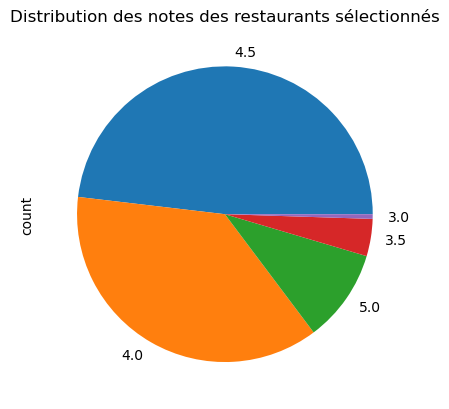

In [7]:
df.rating.value_counts().plot.pie()
plt.title("Distribution des notes des restaurants sélectionnés")